### 0.- This project aims to analyze short time series [1,2] from the sp500. Several papers have been published about the use of random matrix theory [2,3] in financial markets [4], that's our background. We will use the ensemble technique [5] and we will focus on the highly correlation periods. Owing to research purposes I am not allowed to show the results.

### 0.1 References

[1] R. S. Tsay, Analysis of Financial Time Series: Financial Econometrics, Jonh Wiley & Sons,
Inc., 2002.

[2] J.-P. Bouchaud and M. Potters. Theory of Financial Risk and Derivative Pricing: From Sta-
tistical Physics to Risk Management. Cambridge University Press, 2 edition, 2004

[3] G. W. Anderson, A. Guionnet, and O. Zeitouni. An Introduction to Random Matrices. Cam-
bridge Studies in Advanced Mathematics. Cambridge University Press, 1 edition, 2010.

[4] J. Bun, J.-P Bouchaud, M. Potters, Cleaning large Correlation Matrices: tools from Random
Matrix Theory, 2016.

[5] M. Vyas, T. Guhr, and T. H. Seligman. Multivariate analysis of short time series in terms of
ensembles of correlation matrices, Scientific Reports, 2018.

### 1.-  Set up th enviroment

In [1]:
import numpy as np
from numpy import linalg as LA

import scipy as sp
from scipy.optimize import curve_fit

import pandas as pd
import pandas_datareader.data as web 

import bs4 as bs

import os

import datetime as dt

import pickle

import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import copy

import requests

In [2]:
from funciones import econophysics as rmt

### 2.-

In [3]:
# This function creates a list with the list of the sp500 wikipedias web site
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,"lxml")
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        
        mapping = str.maketrans(".","-")
        ticker = ticker.translate(mapping)
        
        ticker = ticker[:-1]
        tickers.append(ticker)
    #with open("sp500tickers.pickle","wb") as f:
        #pickle.dump(tickers, f)

#    for ticker in tickers:
#        ticker[len(ticker) - 1 ] = '\0'    
    
    return tickers 

In [4]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    
    return bins

In [5]:
def epoch(data, window_size = 40, overlap = 0):
    
    time_interval = window_size
    
    E = []
    X = []
    
    j = 0
        
    while len(data[0, (time_interval*j) - overlap*j: (time_interval*(j+1)) - overlap*j]) == time_interval:
        
        E.append( data[:, (time_interval*j) - overlap*j: (time_interval*(j+1)) - overlap*j] )
        j += 1
    
 
    #for Matrix in E:
    #    #X.append( normalization(Matrix) )
    #    X.append(np.corrcoef(normalization(Matrix)))
        
    #return np.stack(X)
    return np.stack(E)

In [6]:
def ensemble(Matrix, members = 50, rows = 38, shuffle = 'Off'):
    
    N = len(Matrix)
    
    first_element = list( np.sort(np.random.choice(N , rows , replace = False) ) )
    
    lista_de_indices =  [ first_element ]
    
    
    i = 0
    
    while i < members - 1 :
        
        indices = 0
        indices = list ( np.sort(np.random.choice(N,rows,replace = False)) )
        
        if (indices in lista_de_indices) == False:
            
            lista_de_indices.append(indices)
            i += 1 
        else :
            i -= 0
            
    if shuffle == 'On':
        
        for lista in lista_de_indices:
            np.random.shuffle(lista)
            
    Matrix = np.stack (Matrix)
    
    E = [ Matrix[ indices ] for indices in lista_de_indices ]
    Ensemble = [ np.corrcoef(matrix) for matrix in E]
    
    return np.stack(Ensemble)  

$$ PR(v) = \frac{1}{\sum_{i}v_{i}^{4}} $$

In [7]:
def pr(vector):
    return 1/np.sum(np.power(vector,4))

In [8]:
def mnorm(Matrix):
    N = Matrix
    for row in N:
        row = (row - np.mean(row))/np.std(row)
    return N    


$$ \rho(\lambda) = \frac{Q}{2\pi (1-c)\sigma^{2}} \frac{\sqrt{(\lambda_{+} - \lambda) (\lambda - \lambda_{-}) } }{\lambda}$$
Where $Q = N/T$ and $\lambda_{\pm} = (1-c)\sigma^{2}\left(1\pm \sqrt{\frac{1}{Q}}\right)^{2}$

In [9]:
def marchenko_pastur_corr(Q, sigma = 1, corrcoef = 0):
    y = 1/Q
    c1 = corrcoef  
    b1 = (1 - c1)*np.power( sigma*( 1 + np.sqrt(1/Q)), 2)
    a1 = (1 - c1)*np.power( sigma*( 1 - np.sqrt(1/Q)), 2)
    
    f = np.vectorize(lambda x,a,b,c:
                     (1/( 2*np.pi*sigma*sigma*x*y*(1-c)))* np.sqrt( (b-x)*(x-a))*(0 if (x > b or x < a or c == 1) else 1) )
    
    x_max = (1 - c1)*np.power( sigma*( 1 + np.sqrt(1/Q)), 2)
    x_min = (1 - c1)*np.power( sigma*( 1 - np.sqrt(1/Q)), 2)
    X = np.linspace(x_min,x_max,1000)
    
    return X , f(X,a1,b1,c1)

In [132]:
def gaussian( X, corrected = False ):
    
    if corrected == False:
        
        x_ = np.linspace(np.min(X), np.max(X), 1000)
        m = np.mean(X)
        s = np.std(X)
        f = np.vectorize( lambda x, mu , sigma : 
                         (1/(np.sqrt(2*np.pi)*sigma))* np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma) ))
#        f = np.vectorize( lambda x, mu , sigma : 
#                         (1/np.sqrt(2*np.pi)*sigma*sigma)* np.exp(-x*x/2 ) ) 

        
        return x_, f(x_,m,s)
    
    
    if corrected == True:
        m = np.mean(X)
        s = np.std(X)
        sk = sp.stats.skew(X)
        k = sp.stats.kurtosis(X)
    
        x_ = np.linspace(np.min(X), np.max(X), 1000)

        x_ = (x_ - m )/s
   #
        He3 = lambda x : np.power(x,3) -3 * x
        He4 = lambda x : np.power(x,4) -6 * np.power(x,2) +3
        He6 = lambda x : np.power(x,6) - 15*np.power(x,4)+ 45*np.power(x,2) -15
   
        f = np.vectorize( lambda x,skew, kur: (1/np.sqrt(2*np.pi))*np.exp(-np.power(x,2)/2) * 
                         (1 + (skew/6)*He3(x) + (kur/24)*He4(x) + (np.power(skew,2)/72)*He6(x) )
                        )
    
        return x_, f(x_,sk,k)

In [133]:
def gaussian2( X, corrected = False ):
    
    if corrected == False:
        
        x_ = np.linspace(np.min(X), np.max(X), 1000)
        m = np.mean(X)
        s = np.std(X)
        
        x_ = (x_ - m)/s

        f = np.vectorize( lambda x, mu , sigma : 
                         (1/np.sqrt(2*np.pi))* np.exp(-np.power(x,2)/2 ) ) 

        
        return x_, f(x_,m,s)
    
    
    if corrected == True:
        m = np.mean(X)
        s = np.std(X)
        sk = sp.stats.skew(X)
        k = sp.stats.kurtosis(X)
    
        x_ = np.linspace(np.min(X), np.max(X), 1000)

        x_ = (x_ - m )/s
   #
        He3 = lambda x : np.power(x,3) -3 * x
        He4 = lambda x : np.power(x,4) -6 * np.power(x,2) +3
        He6 = lambda x : np.power(x,6) - 15*np.power(x,4)+ 45*np.power(x,2) -15
   
        f = np.vectorize( lambda x,skew, kur: (1/np.sqrt(2*np.pi))*np.exp(-np.power(x,2)/2) * 
                         (1 + (skew/6)*He3(x) + (kur/24)*He4(x) + (np.power(skew,2)/72)*He6(x) )
                        )
    
        return x_, f(x_,sk,k)

In [136]:
def histogramas(lista1, lista2, corrcoef, epocas = 0 ,couleur = 'Blue',parte = 1, overlap = False ):
#def histogramas(lista1 , lista2 , pdf, avg,couleur = 'Blue',epoca = 51 ):
    
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (14,16))
    plt.subplots_adjust(wspace= 0.20,hspace = 0.30,top = 0.93)
    
    if overlap == False:
        plt.suptitle('Eigenvalues distribution by epoch',fontsize = 15)
    else:
        plt.suptitle('Distribución de eigenvalores del ensemble de distintas épocas con un overlap de 20 días',
                     fontsize = 15)
        
    k = 0
    if parte == 1: 
        k = 0
    if parte == 2:
        k = 8
    if parte == 3:
        k = 16
    for i in range(4):
        for j in range(2):
            if 2*i+j+k >= 22:
                ax[i,j].axis('Off')
            else:
                x1 , f1 = marchenko_pastur_corr( Q = (10/8), corrcoef = corrcoef[2*i+j + k])
                x2 , f2 = gaussian( lista2[2*i+j + k] )
                
                xa , xb = np.min(x2) , np.max(x2)
    
                bins1 = compute_histogram_bins( lista1[2*i+j + k], 0.1)
                
                ax[i,j].hist(lista1[2*i+j + k], color = couleur[2*i+j + k], ec  = 'white', bins = 100, density = True)
                ax[i,j].plot( x1, f1, color = 'coral')
    
                #axins = inset_axes(ax[i,j], width=3, height=1.7)
    
                #axins.hist( lista1[2*i+j + k], color = couleur[2*i+j + k] , ec='white',bins = bins1, density=True)
    
                #axins.set_ylim(0,0.03)#0.016
                #axins.set_xlim(xa,xb)
                
                ax[i,j].set_title('Época ' + str(epocas[2*i+j + k]) )
                ax[i,j].set_xlabel('$\lambda$',fontsize = 12)
                ax[i,j].set_ylabel('$p(\lambda)$', fontsize =12)
                ax[i,j].set_ylim(0,2.8)
                #ax[i,j].indicate_inset_zoom(axins)

    plt.show()

In [12]:
def distribucion_emax(lista1 , epocas = 0 , couleur = 'blue', parte = 1,overlap = False):
    
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (14,16))
    plt.subplots_adjust(wspace= 0.20,hspace = 0.30,top = 0.93)
    
    if overlap == False:
        plt.suptitle('Distribución del eigenvalor más grande de distintas épocas',fontsize = 15)    
    else:
        plt.suptitle('Distribución del eigenvalor más grande de distintas épocas con un overlap de 20 días',
                     fontsize = 15)         
    k = 0
    
    if parte == 2:
        k = 8
    if parte == 3:
        k = 16
    
    for i in range(4):
        for j in range(2):
            if 2*i+j+k >= 22:
                ax[i,j].axis('Off')
            else:
                emaxt = (lista1[2*i+j + k] - np.mean(lista1[2*i+j + k]) )/np.std(lista1[2*i+j + k])
                bins1 = compute_histogram_bins(emaxt, 0.06)
            
                x1, f1 = gaussian2(lista1[2*i+j + k])
                x2, f2 = gaussian2(lista1[2*i+j + k],corrected = True)
                
                ax[i,j].hist(emaxt,color=couleur[2*i+j + k],ec='white',bins=bins1,density=True)
                ax[i,j].plot(x1,f1, color = 'salmon', linewidth = 2.5,label = 'Gaussiana')
                ax[i,j].plot(x2,f2, color = 'y', linewidth = 2.5,label = 'Corrección-Gaussiana')
                
                ax[i,j].set_title('Época '+str(epocas[2*i+j + k]))
                ax[i,j].set_ylabel('$P(\hat{\lambda})$')
                ax[i,j].set_xlabel('$\hat{\lambda}$')
                ax[i,j].legend(loc='best')
     
    plt.plot()

In [13]:
def histogramas_smallest(lista1, epocas = 0 ,couleur = 'Blue',parte = 1, overlap = False ):
#def histogramas(lista1 , lista2 , pdf, avg,couleur = 'Blue',epoca = 51 ):
    
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (14,16))
    plt.subplots_adjust(wspace= 0.20,hspace = 0.30,top = 0.93)
    
    if overlap == False:
        plt.suptitle('Distribución de eigenvalores del ensemble de distintas épocas',fontsize = 15)
    else:
        plt.suptitle('Distribución de eigenvalores del ensemble de distintas épocas con un overlap de 20 días',
                     fontsize = 15)
    #x1,y1 = smallest_distribution()
    
    
        
    k = 0
    if parte == 1: 
        k = 0
    if parte == 2:
        k = 8
    if parte == 3:
        k = 16
    for i in range(4):
        for j in range(2):
            if 2*i+j+k >= 22:
                ax[i,j].axis('Off')
            else:

                bins1 = compute_histogram_bins( lista1[2*i+j + k], 0.0001)
                
                ax[i,j].hist(lista1[2*i+j + k], color = couleur[2*i+j + k], ec  = 'white', bins = 100, density = True,
                             stacked=True)
               # ax[i,j].plot(x1,y1,color='red',linewidth=2)

                
                ax[i,j].set_title('Época ' + str(epocas[2*i+j + k]) )
                ax[i,j].set_xlabel('$\lambda$',fontsize = 12)
                ax[i,j].set_ylabel('$p(\lambda)$', fontsize =12)



    plt.show()

In [14]:
def exp_fit(x, a, b, c):
    return a * np.exp(-b * x) + c
  #return a * np.log(b * x) + c 

### 3.- 

In [11]:
tickers = save_sp500_tickers() #Saving the tickers in this list
#tickers

In [12]:
tickers.remove('AEP')

In [13]:
tickers.remove('CTVA')

In [14]:
tickers.remove('DOW')

In [15]:
tickers.remove('FOX')

In [16]:
tickers.remove('FOXA')

In [17]:
tickers.remove('NLOK')

In [18]:
#156,203,204,349

In [19]:
len(tickers)

499

In [20]:
tickers[32]

'AXP'

In [21]:
tickers[495:500]

['YUM', 'ZBH', 'ZION', 'ZTS']

In [22]:
tickers[203]

'FCX'

In [23]:
start = dt.datetime(2018,5,24)  #Parameters
end   = dt.datetime(2019,2,9)       

df = web.DataReader(tickers,'yahoo',start,end)['Adj Close'] 

In [52]:
#df.plot()

In [26]:
#null_columns=df.columns[df.isnull().any()]
#df[null_columns].isnull().sum()

In [27]:
#df.shape

In [28]:
#df1 = copy.copy(df)

In [29]:
#df1.drop('BKR',axis = 1,inplace=True) #Deleting the rows with NAN

In [32]:
df1.shape

(179, 499)

In [33]:
null_columns=df1.columns[df1.isnull().any()]
df1[null_columns].isnull().sum()

Series([], dtype: float64)

In [34]:
#df1.to_csv('178_days.csv')

In [35]:
df1 = pd.read_csv('178_days.csv')

In [36]:
df2 = df1.T

In [37]:
data = df2.values

In [38]:
data = np.delete(data, (0), axis = 0)

In [39]:
data = np.delete(data, (31), axis = 0)

In [40]:
#for i,time_series in enumerate(data):
#    plt.plot(time_series)
#    plt.title(str(i))
#    plt.show()

In [42]:
#data

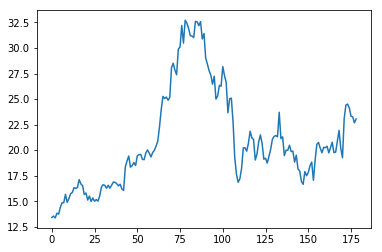

In [43]:
plt.plot(data[31])
plt.show()

$$ R(t) = \frac{p(t) - p(t-1)}{p(t-1)} $$ 

In [45]:
Rendimientos = rmt.returns(data)

$$ r(t) = \frac{R(t) - \mu}{\sigma} $$

In [46]:
N = mnorm(Rendimientos)

In [47]:
len(N[0])

178

### Correlation Matrix
$$ C_{i,j}= \frac{\langle r_{i}r_{j}\rangle - \langle r_{i}\rangle \langle r_{j} \rangle}
{\sqrt{(\langle r_{i}^{2}\rangle-\langle r_{i} \rangle ^{2})(\langle r_{j}^{2}\rangle-\langle r_{j} \rangle ^{2})}}$$

In [48]:
Correlation_matrix = np.corrcoef(N)

In [49]:
Correlation_matrix.shape

(497, 497)

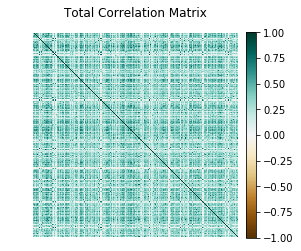

In [50]:
plt.matshow(Correlation_matrix,cmap = plt.cm.BrBG,vmin =-1,vmax =1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Total Correlation Matrix')
plt.show()

In [51]:
U, V = LA.eigh(Correlation_matrix)

In [52]:
bins1 = compute_histogram_bins( U, 1)

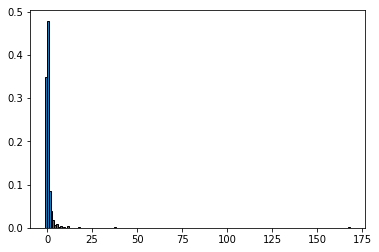

In [53]:
plt.hist(U,bins=bins1,ec = 'black',density = True)
plt.show()

In [54]:
Matrices = epoch(N, window_size = 10,overlap = 9)

In [55]:
Matrices.shape

(169, 497, 10)

In [56]:
C = np.stack([np.corrcoef(matrix) for matrix in Matrices]) 

$$ \langle C \rangle = \frac{1}{N(N-1)} \sum_{ij}(C_{ij}- N)$$ 

In [122]:
corr_avg = [ rmt.average_correlation(matrix) for matrix in C]

In [119]:
u, v = LA.eigh(C)

In [59]:
#u[:,-1]

In [60]:
#corr_avg

In [61]:
#plt.matshow(C[35],cmap = plt.cm.BrBG,vmin =-1,vmax =1)
#plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
#plt.title('Total Correlation Matrix')
#plt.show()

In [78]:
selected_epochs = [20,53,76,92,124,143,154,165]

In [89]:
corr_coef = [corr_avg[epoch] for epoch in selected_epochs]

In [91]:
#corr_coef

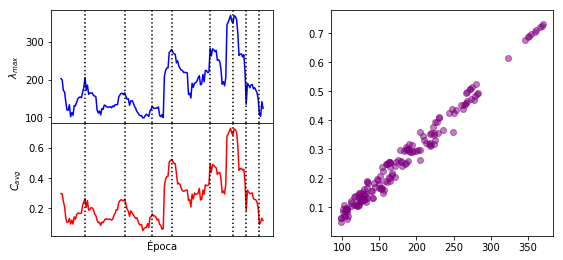

In [82]:
fig = plt.figure(figsize=(9, 4))

grid = plt.GridSpec(3, 4, hspace=0, wspace=0.7,top=1.3)
#plt.suptitle('Comparación entre de los eigenvalores para $q = 1.0$ y $ q = 1.005$')


s_main  = fig.add_subplot(grid[1:, -2:])
s1 = fig.add_subplot(grid[1, :-2] )
s2 = fig.add_subplot(grid[-1, :2], sharex=s1)

#r = '$p_{cc} = $ ' "%3.6f"%(sp.stats.pearsonr(u[:,-1], corr_avg )[0])

s_main.scatter(u[:,-1],corr_avg,color='purple',alpha = 0.5)
#s_main.legend(loc = 'best')
#s_main.set_title('Dispersión')
#s_main.set_ylabel('$\lambda_{max}$'+'  '+'$q = 1.0$')
#s_main.set_xlabel('$\lambda_{max}$'+'  '+'$q = 1.005$')

s1.plot(u[:,-1],color='blue',label = 'q = 1.0')
s1.set_ylabel('$\lambda_{max}$')

#s1.set_xlabel('Época')
s1.get_xaxis().set_ticks([])
#s1.legend(loc = 'best')


s2.plot(corr_avg,color='red', label = 'q = 1.005')
s2.set_ylabel('$C_{avg}$')
s2.set_xlabel('Época')
#s2.legend(loc = 'best')

for epoch in selected_epochs:
    s1.axvline(epoch,linestyle = ':', color = 'black')
    s2.axvline(epoch,linestyle = ':', color = 'black')
    
plt.show()

In [118]:
#len(u[:,-1])

In [80]:
#for epoca, i in enumerate(corr_avg):
#    print(epoca,i )

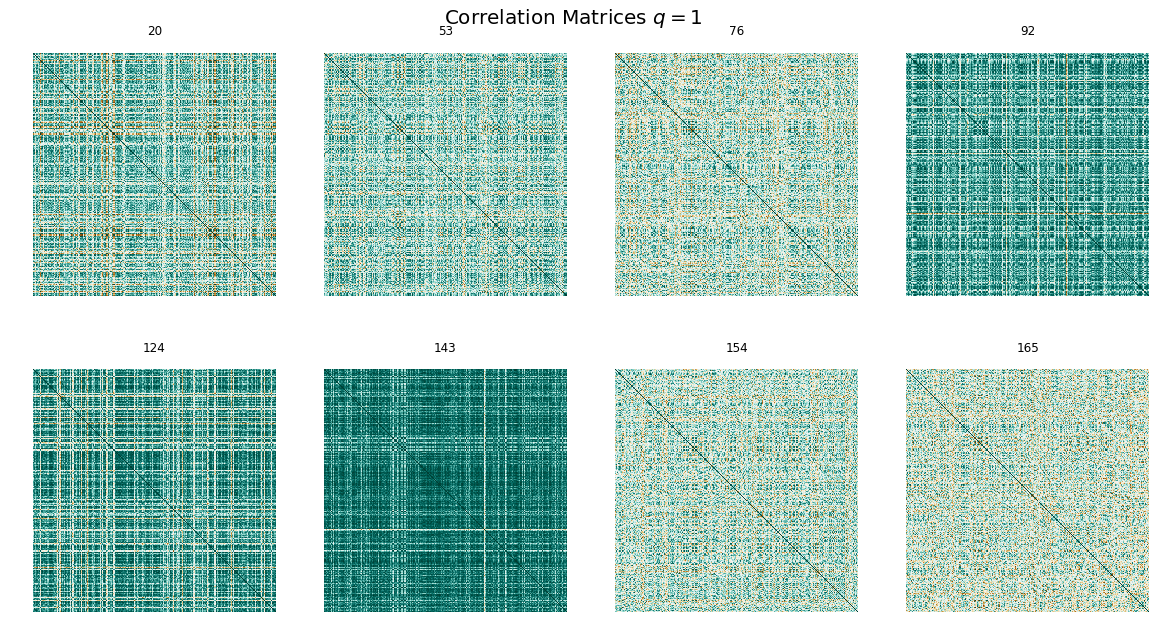

In [86]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))

plt.subplots_adjust(wspace= 0.20,hspace = 0.20,top = 0.93)
plt.suptitle('Correlation Matrices $q = 1$',fontsize = 20)


ax[0,0].matshow(C[20] ,cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[0,1].matshow(C[53] ,cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[0,2].matshow(C[76] ,cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[0,3].matshow(C[92] ,cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[1,0].matshow(C[124],cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[1,1].matshow(C[143],cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[1,2].matshow(C[154],cmap = plt.cm.BrBG,vmin =-1,vmax =1)
ax[1,3].matshow(C[165],cmap = plt.cm.BrBG,vmin =-1,vmax =1)

ax[0,0].set_title('20')
ax[0,0].axis('off')

ax[0,1].set_title('53')
ax[0,1].axis('off')

ax[0,2].set_title('76')
ax[0,2].axis('off')

ax[0,3].set_title('92')
ax[0,3].axis('off')

ax[1,0].set_title('124')
ax[1,0].axis('off')

ax[1,1].set_title('143')
ax[1,1].axis('off')

ax[1,2].set_title('154')
ax[1,2].axis('off')

ax[1,3].set_title('165')
ax[1,3].axis('off')


#plt.colorbar(ticks = range(-1,0,1))
plt.show()

In [110]:
Distribution = []
emax = []
emin = []
#PR_max = []
#PR_min = []
AVG = []

In [111]:
len(Matrices)

169

In [112]:
#for epoca in range(len(Matrices)):
for epoca in selected_epochs :
    e, u, v = 0 ,0 ,0  

    #v_max = 0
    #v_min = 0
    #pr_max= 0
    #pr_min= 0
    avg = 0
    
    e = ensemble( Matrices[epoca], rows = 8,members = 10000, shuffle = 'On')
    
    u, v = LA.eigh(e)
    
    Distribution.append( np.ndarray.flatten(u) )
    emax.append( u[:,-1])
    emin.append( u[:,0])
    
    avg = [np.mean(correlation_matrix) for correlation_matrix in e]
    #v_max = [ v[i][:,-1] for i in range( len(v)) ]
    #v_min = [ v[i][:,0] for i in range( len(v)) ]

    #pr_min = [pr(vector) for vector in v_min]
    #pr_max = [pr(vector) for vector in v_max]
    
    AVG.append(avg)
    
    #PR_max.append(pr_max)
    #PR_min.append(pr_min)

In [113]:
color = ['blue', 'slateblue','darkslateblue','navy','darkblue',
           'mediumblue', 'deepskyblue','skyblue','dodgerblue','lightskyblue',
           'darkturquoise','cadetblue','darkcyan','c','aqua',
           'green','darkgreen']

In [96]:
#x, f = marchenko_pastur(Q = (40/38))

In [104]:
emax_avg = np.array([np.mean(lista) for lista in emax])

In [108]:
emax_avg

array([3.81248522, 3.77462927, 3.44437283, 3.39030717, 3.11378058,
       2.93539641, 2.95459612, 3.06342965, 2.83114946, 2.88148279,
       2.84306463, 3.0449563 , 3.04741873, 3.12544146, 3.2215313 ,
       3.24102542, 3.23504525, 3.23154115, 3.40105378, 3.54552265,
       3.85888695, 3.46943483, 3.63816797, 3.36283063, 3.40288671,
       3.41885648, 3.42498876, 3.37615489, 3.34046762, 3.29950093,
       3.03142298, 2.96571274, 2.98091418, 2.94235148, 3.02840445,
       2.98806356, 3.08106523, 3.05180077, 3.03696793, 3.02307724,
       3.02313563, 3.02995556, 3.02932399, 3.06031314, 3.0503103 ,
       3.06331419, 3.0861594 , 3.1283424 , 3.30992251, 3.34885398,
       3.38408228, 3.40265527, 3.38095352, 3.45481219, 3.34455537,
       3.28715054, 3.27893244, 3.07565439, 3.16487772, 3.14404881,
       3.13509669, 3.12776034, 3.07200031, 3.00171102, 2.94513892,
       2.88839636, 2.88856799, 2.88406011, 2.82544338, 2.83446755,
       2.85887837, 2.88723362, 2.87328388, 2.87355597, 2.99072

In [105]:
avg_avg = np.array([np.mean(lista) for lista in AVG])

In [109]:
avg_avg

array([0.38411855, 0.38348765, 0.33709509, 0.30981144, 0.24148228,
       0.21590766, 0.21975304, 0.24037548, 0.20636507, 0.23014106,
       0.20771401, 0.24870828, 0.23727216, 0.26148846, 0.27308472,
       0.26855622, 0.26895549, 0.27062543, 0.31735067, 0.33721783,
       0.35445922, 0.30438454, 0.34405836, 0.28640186, 0.29167938,
       0.30309637, 0.301546  , 0.2914284 , 0.26445488, 0.2562958 ,
       0.22989656, 0.21668581, 0.22039074, 0.20141824, 0.21925824,
       0.21574905, 0.22771502, 0.23833367, 0.23521645, 0.23419044,
       0.23541829, 0.2368267 , 0.23181273, 0.23591626, 0.25717581,
       0.26989246, 0.29173172, 0.29041189, 0.33445332, 0.34398713,
       0.34848387, 0.3449888 , 0.3422614 , 0.35137167, 0.32307187,
       0.29568446, 0.28297749, 0.25436095, 0.28622243, 0.27276306,
       0.26253967, 0.25215175, 0.23956411, 0.24486195, 0.22665458,
       0.20731455, 0.20259111, 0.2043959 , 0.16908621, 0.18069563,
       0.18729935, 0.1871764 , 0.21073381, 0.1867112 , 0.24740

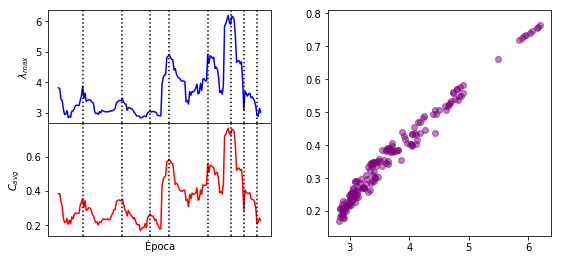

In [106]:
fig = plt.figure(figsize=(9, 4))

grid = plt.GridSpec(3, 4, hspace=0, wspace=0.7,top=1.3)
#plt.suptitle('Comparación entre de los eigenvalores para $q = 1.0$ y $ q = 1.005$')


s_main  = fig.add_subplot(grid[1:, -2:])
s1 = fig.add_subplot(grid[1, :-2] )
s2 = fig.add_subplot(grid[-1, :2], sharex=s1)

#r = '$p_{cc} = $ ' "%3.6f"%(sp.stats.pearsonr(u[:,-1], corr_avg )[0])

s_main.scatter(emax_avg,avg_avg,color='purple',alpha = 0.5)
#s_main.legend(loc = 'best')
#s_main.set_title('Dispersión')
#s_main.set_ylabel('$\lambda_{max}$'+'  '+'$q = 1.0$')
#s_main.set_xlabel('$\lambda_{max}$'+'  '+'$q = 1.005$')

s1.plot(emax_avg,color='blue',label = 'q = 1.0')
s1.set_ylabel('$\lambda_{max}$')

#s1.set_xlabel('Época')
s1.get_xaxis().set_ticks([])
#s1.legend(loc = 'best')


s2.plot(avg_avg,color='red', label = 'q = 1.005')
s2.set_ylabel('$C_{avg}$')
s2.set_xlabel('Época')
#s2.legend(loc = 'best')

for epoch in selected_epochs:
    s1.axvline(epoch,linestyle = ':', color = 'black')
    s2.axvline(epoch,linestyle = ':', color = 'black')
    
plt.show()

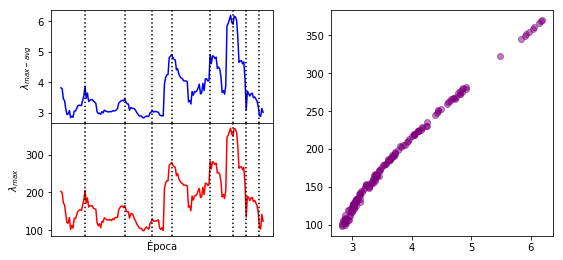

In [121]:
fig = plt.figure(figsize=(9, 4))

grid = plt.GridSpec(3, 4, hspace=0, wspace=0.7,top=1.3)
#plt.suptitle('Comparación entre de los eigenvalores para $q = 1.0$ y $ q = 1.005$')


s_main  = fig.add_subplot(grid[1:, -2:])
s1 = fig.add_subplot(grid[1, :-2] )
s2 = fig.add_subplot(grid[-1, :2], sharex=s1)

#r = '$p_{cc} = $ ' "%3.6f"%(sp.stats.pearsonr(u[:,-1], corr_avg )[0])

s_main.scatter(emax_avg,u[:,-1],color='purple',alpha = 0.5)
#s_main.legend(loc = 'best')
#s_main.set_title('Dispersión')
#s_main.set_ylabel('$\lambda_{max}$'+'  '+'$q = 1.0$')
#s_main.set_xlabel('$\lambda_{max}$'+'  '+'$q = 1.005$')

s1.plot(emax_avg,color='blue',label = 'q = 1.0')
s1.set_ylabel('$\lambda_{max-avg}$')

#s1.set_xlabel('Época')
s1.get_xaxis().set_ticks([])
#s1.legend(loc = 'best')


s2.plot(u[:,-1],color='red', label = 'q = 1.005')
s2.set_ylabel('$\lambda_{max}$')
s2.set_xlabel('Época')
#s2.legend(loc = 'best')

for epoch in selected_epochs:
    s1.axvline(epoch,linestyle = ':', color = 'black')
    s2.axvline(epoch,linestyle = ':', color = 'black')
    
plt.show()

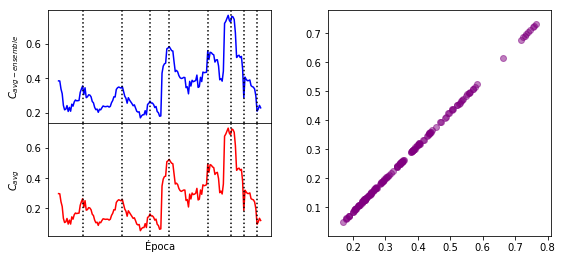

In [123]:
fig = plt.figure(figsize=(9, 4))

grid = plt.GridSpec(3, 4, hspace=0, wspace=0.7,top=1.3)
#plt.suptitle('Comparación entre de los eigenvalores para $q = 1.0$ y $ q = 1.005$')


s_main  = fig.add_subplot(grid[1:, -2:])
s1 = fig.add_subplot(grid[1, :-2] )
s2 = fig.add_subplot(grid[-1, :2], sharex=s1)

#r = '$p_{cc} = $ ' "%3.6f"%(sp.stats.pearsonr(u[:,-1], corr_avg )[0])

s_main.scatter(avg_avg,corr_avg,color='purple',alpha = 0.5)
#s_main.legend(loc = 'best')
#s_main.set_title('Dispersión')
#s_main.set_ylabel('$\lambda_{max}$'+'  '+'$q = 1.0$')
#s_main.set_xlabel('$\lambda_{max}$'+'  '+'$q = 1.005$')

s1.plot(avg_avg,color='blue',label = 'q = 1.0')
s1.set_ylabel('$C_{avg-ensemble}$')

#s1.set_xlabel('Época')
s1.get_xaxis().set_ticks([])
#s1.legend(loc = 'best')


s2.plot(corr_avg,color='red', label = 'q = 1.005')
s2.set_ylabel('$C_{avg}$')
s2.set_xlabel('Época')
#s2.legend(loc = 'best')

for epoch in selected_epochs:
    s1.axvline(epoch,linestyle = ':', color = 'black')
    s2.axvline(epoch,linestyle = ':', color = 'black')
    
plt.show()

In [124]:
avg2 = np.array([np.mean(lista) for lista in AVG])

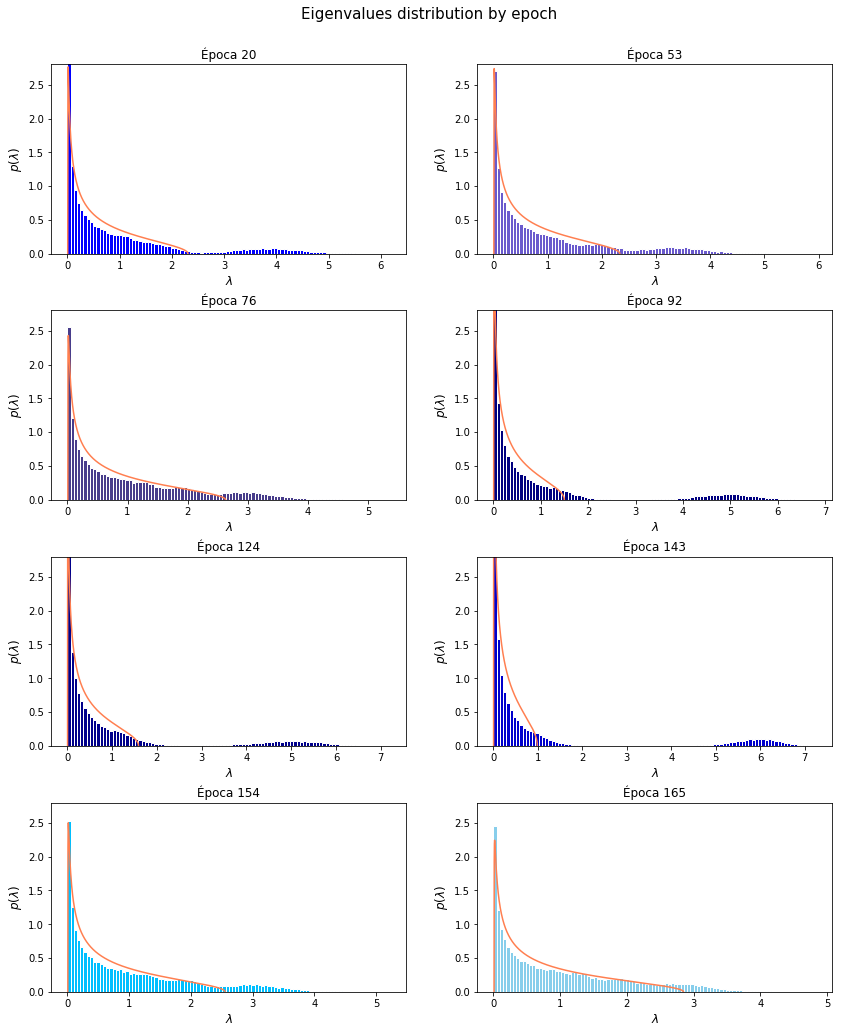

In [137]:
histogramas(Distribution, emax, avg2, epocas = selected_epochs ,couleur = color,parte = 1, overlap = False )

### Gaussian distibution
$$ f(\hat{E}) = \frac{1}{\sqrt{2\pi}}\exp{\left(-\hat{E}^{2}\right)}$$
$$ g(\hat{E}) = \frac{1}{\sqrt{2\pi}}\exp{\left(-\hat{E}^{2}\right)}\{1+\frac{\mu_{3}}{6}He_{3}(\hat{E})+
\frac{\mu_{4}}{24}He_{4}(\hat{E})\frac{\mu_{3}^{2}}{72}He_{6}(\hat{E})\}$$

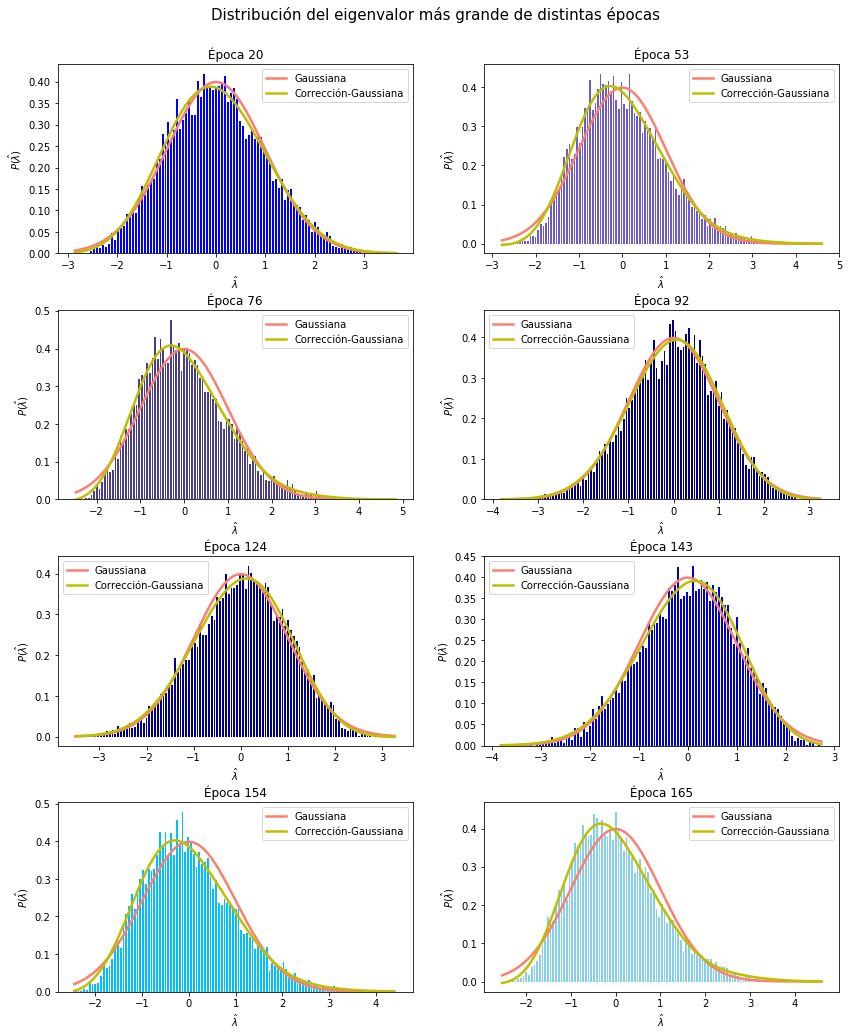

In [138]:
distribucion_emax(emax , epocas = selected_epochs , couleur = color, parte = 1,overlap = False)